In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

toload = [ 
    # dict(name="old_hires", id="d42acb-with_guards", unnormalise = True, squash = True), 
    # dict(name="orig_lores", id="t9b-nonortho_xpoint_afn", unnormalise = True, squash = False), 
    dict(name="rerun_lores", id="upst7a-2e19_from_t9b-nonortho_xpoint_afn", unnormalise = True, squash = False), 
    dict(name="clim1", id="upst7b-clim_1.0", unnormalise = True, squash = False), 
    dict(name="clim1_mfp1", id="upst7c-clim_1.0_maxmfp_1", unnormalise = True, squash = False), 
    dict(name="clim1_mfp1k", id="upst7cb-clim_1.0_maxmfp_10000", unnormalise = True, squash = False), 
    
    
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst7a-2e19_from_t9b-nonortho_xpoint_afn
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case upst7b-clim_1.0
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case upst7c-clim_1.0_maxmfp_1
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case upst7cb-clim_1.0_maxmfp_10000
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


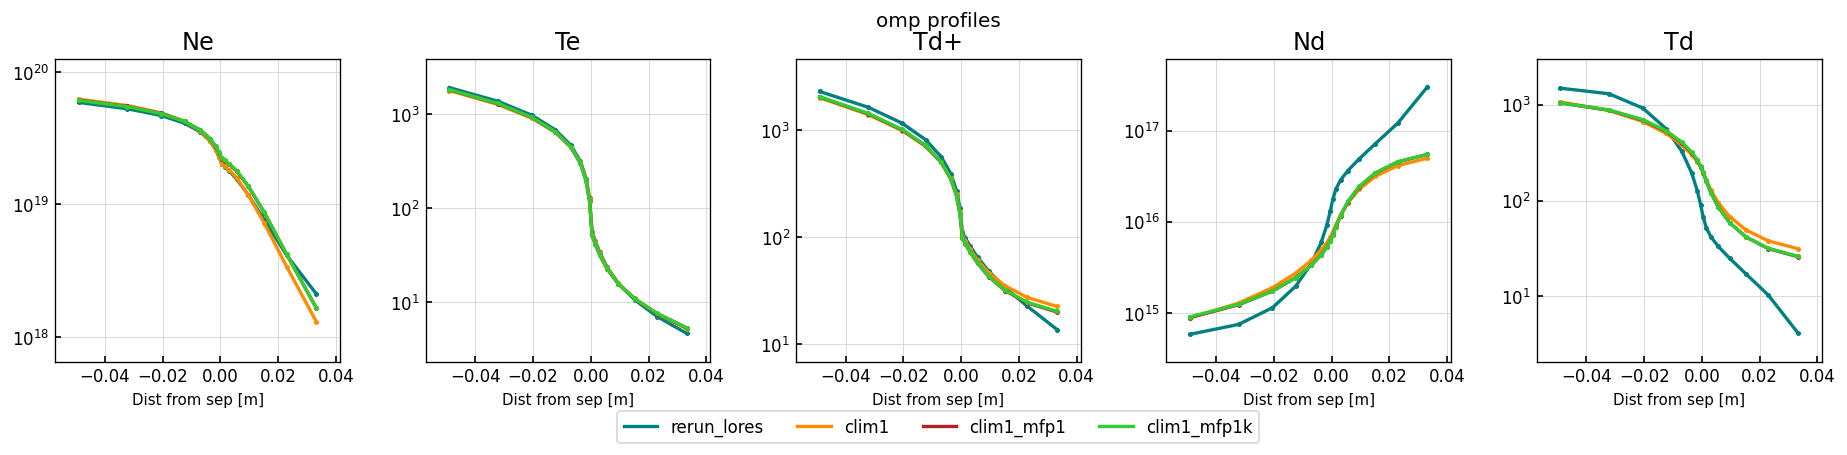

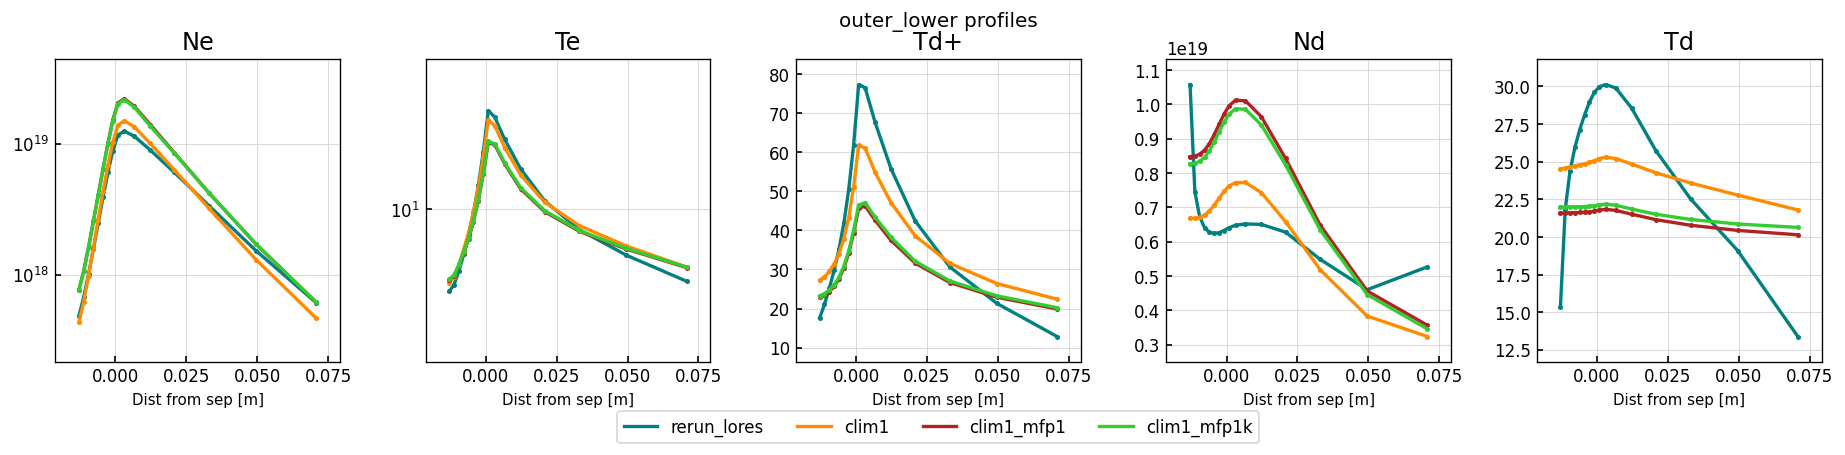

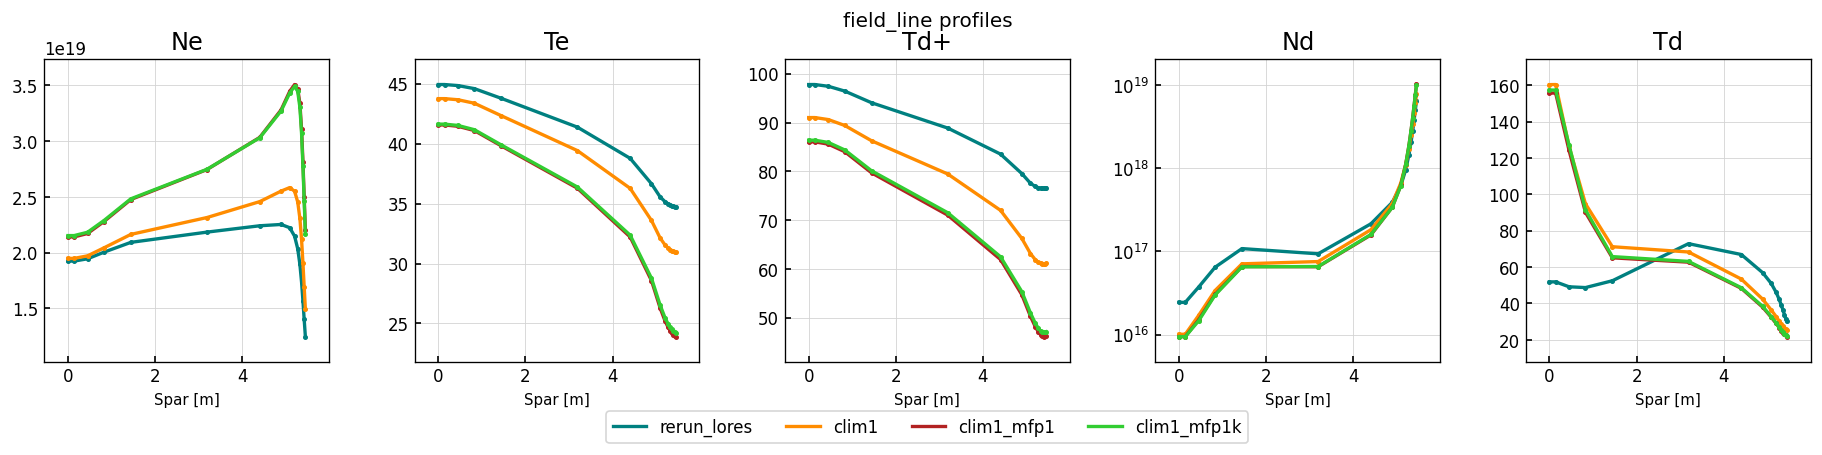

In [3]:
toplot = {}
for case in cs:
# for case in ["test_legacy", "test_afn"]:

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    toplot[case] = ds
    
lineplot(
    toplot,
    # clean_guards = False,
    logscale = True,
    params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # params = ["Nd", "Dnnd"],
    regions = ["omp", "outer_lower", "field_line"],
    # regions = ["omp", "outer_lower"],
)

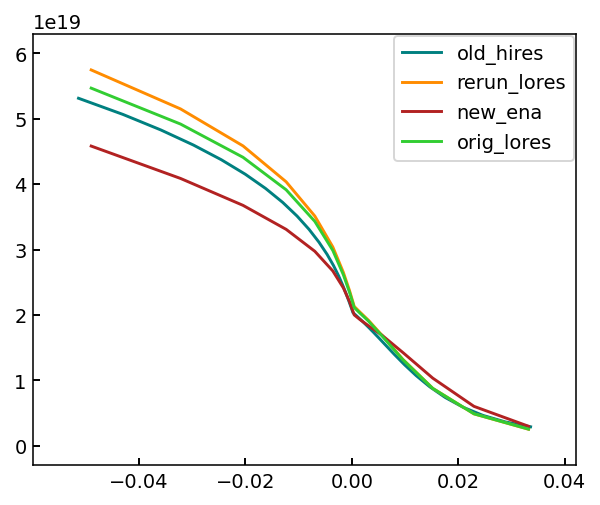

In [18]:
fig, ax = plt.subplots()
for name, ds in toplot.items():
    df = get_1d_radial_data(cs[name].ds.isel(t=-1), ["Ne", "Te"], "omp")
    ax.plot(df["Srad"], df["Ne"], label = name)
    
ax.legend()

In [10]:
toplot

{'old_hires': <xarray.Dataset> Size: 4MB
 Dimensions:                  (x: 36, theta: 108)
 Coordinates: (12/24)
     dx                       (x, theta) float64 31kB dask.array<chunksize=(36, 108), meta=np.ndarray>
     dy                       (x, theta) float64 31kB dask.array<chunksize=(36, 108), meta=np.ndarray>
     dz                       (x, theta) float64 31kB dask.array<chunksize=(36, 108), meta=np.ndarray>
     zShift                   (x, theta) float64 31kB dask.array<chunksize=(36, 108), meta=np.ndarray>
     t                        float64 8B 0.04484
     R                        (x, theta) float64 31kB 0.2632 0.267 ... 0.6208
     ...                       ...
     Zxy_upper_right_corners  (x, theta) float64 31kB -0.7437 -0.7446 ... -0.8175
     psi_poloidal             (x, theta) float64 31kB -0.02408 ... 0.007188
   * x                        (x) int64 288B 2 3 4 5 6 7 8 ... 32 33 34 35 36 37
   * theta                    (theta) float64 864B 0.07854 0.2356 ... 16.7

/tmp/ipykernel_949164/2725589037.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(toplot, labels = params, patch_artist = True, whis = (5, 95), flierprops = {"ms":1, "markerfacecolor":"k", "color":"grey", "mew":0.2})


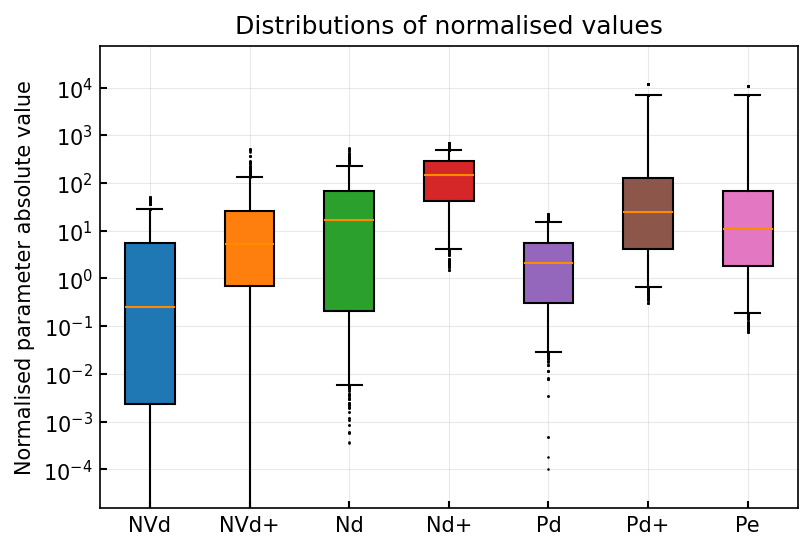

In [5]:
ds = cs["new"].ds
if "t" in ds.sizes: ds.isel(t=-1)

# for param in ["Ne", "Te"]:

data = ds["Ne"].values.flatten()


fig, ax = plt.subplots(figsize = (6,4), dpi = 150)    

# bins = 100000

toplot = []
params = ["NVd", "NVd+", "Nd", "Nd+", "Pd", "Pd+", "Pe"]
colors = [plt.get_cmap("tab10")(x) for x in range(len(params))]

for i, param in enumerate(params):
    data = ds[param] / ds[param].conversion   # Make sure it's normalised
    toplot.append(abs(data).values.flatten())

bplot = ax.boxplot(toplot, labels = params, patch_artist = True, whis = (5, 95), flierprops = {"ms":1, "markerfacecolor":"k", "color":"grey", "mew":0.2})
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)

ax.set_yscale("log")
ax.grid(alpha=0.5)
ax.set_ylabel("Normalised parameter absolute value")
ax.set_title("Distributions of normalised values")

ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=15))
print()

new 2.2900051583254444e+16 -9.316200303223805e+20


KeyError: 'fix'

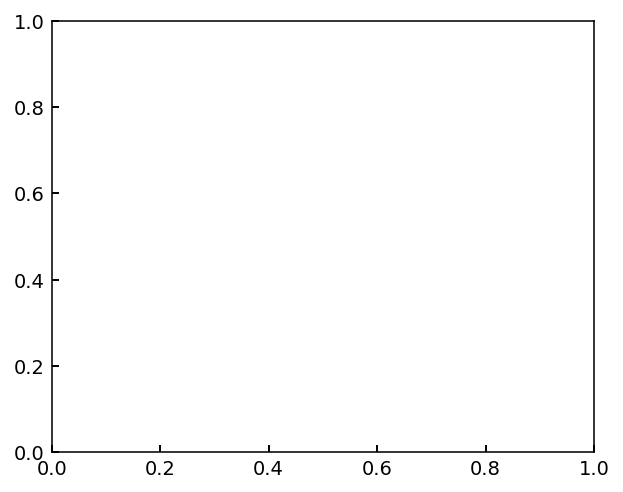

In [6]:
fig, ax =plt.subplots()

for name in ["new", "fix"]:
    
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)

    avg_dens = (ds["Ne"] * ds["is_pump"]).mean().values
    
    source = (ds["Sd_pump"]).mean().values
    print(name, avg_dens, source)
    


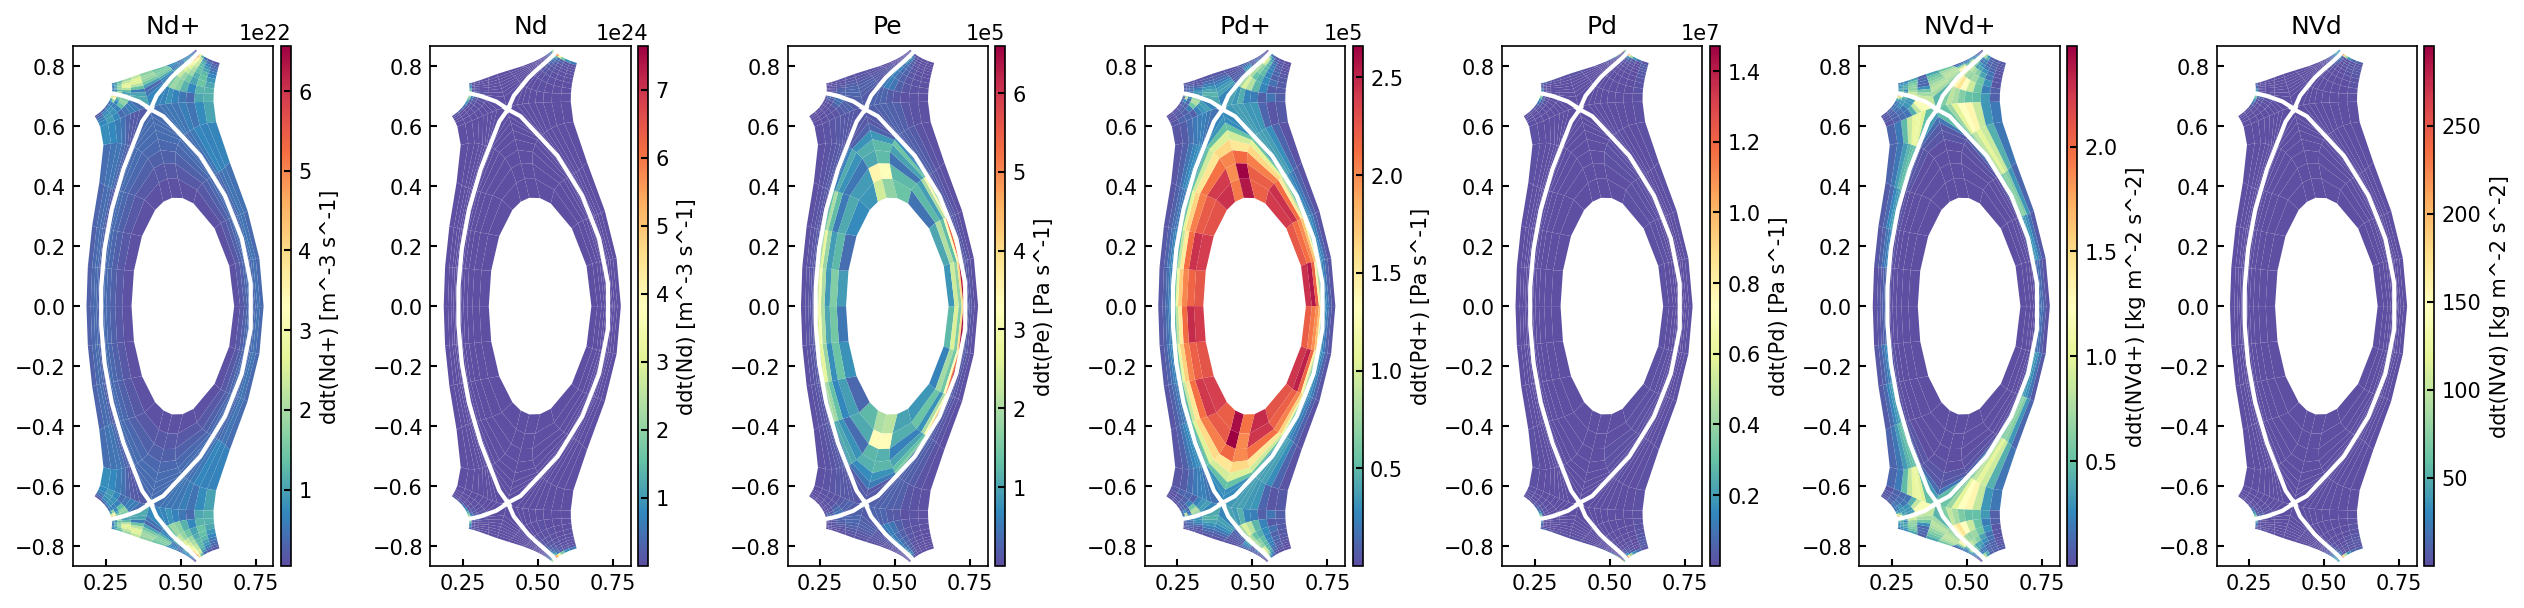

In [ ]:
fig, axes = plt.subplots(1,7, figsize = (3.0*7,4.5), dpi = 150)
cmap = "Spectral_r"

name = "fix"

ds = cs[name].ds

for i, param in enumerate(["Nd+", "Nd", "Pe", "Pd+", "Pd", "NVd+", "NVd"]):
  
  if "t" in ds.sizes:
    fluctuations = np.sqrt((ds[f"ddt({param})"]**2).mean(dim="t"))
  else:
    fluctuations = np.abs(ds[f"ddt({param})"])
  data = fluctuations #/ds[param]
  
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                        # colorbar_label="Test",
                                                        antialias = True,
                                                        logscale = False,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")

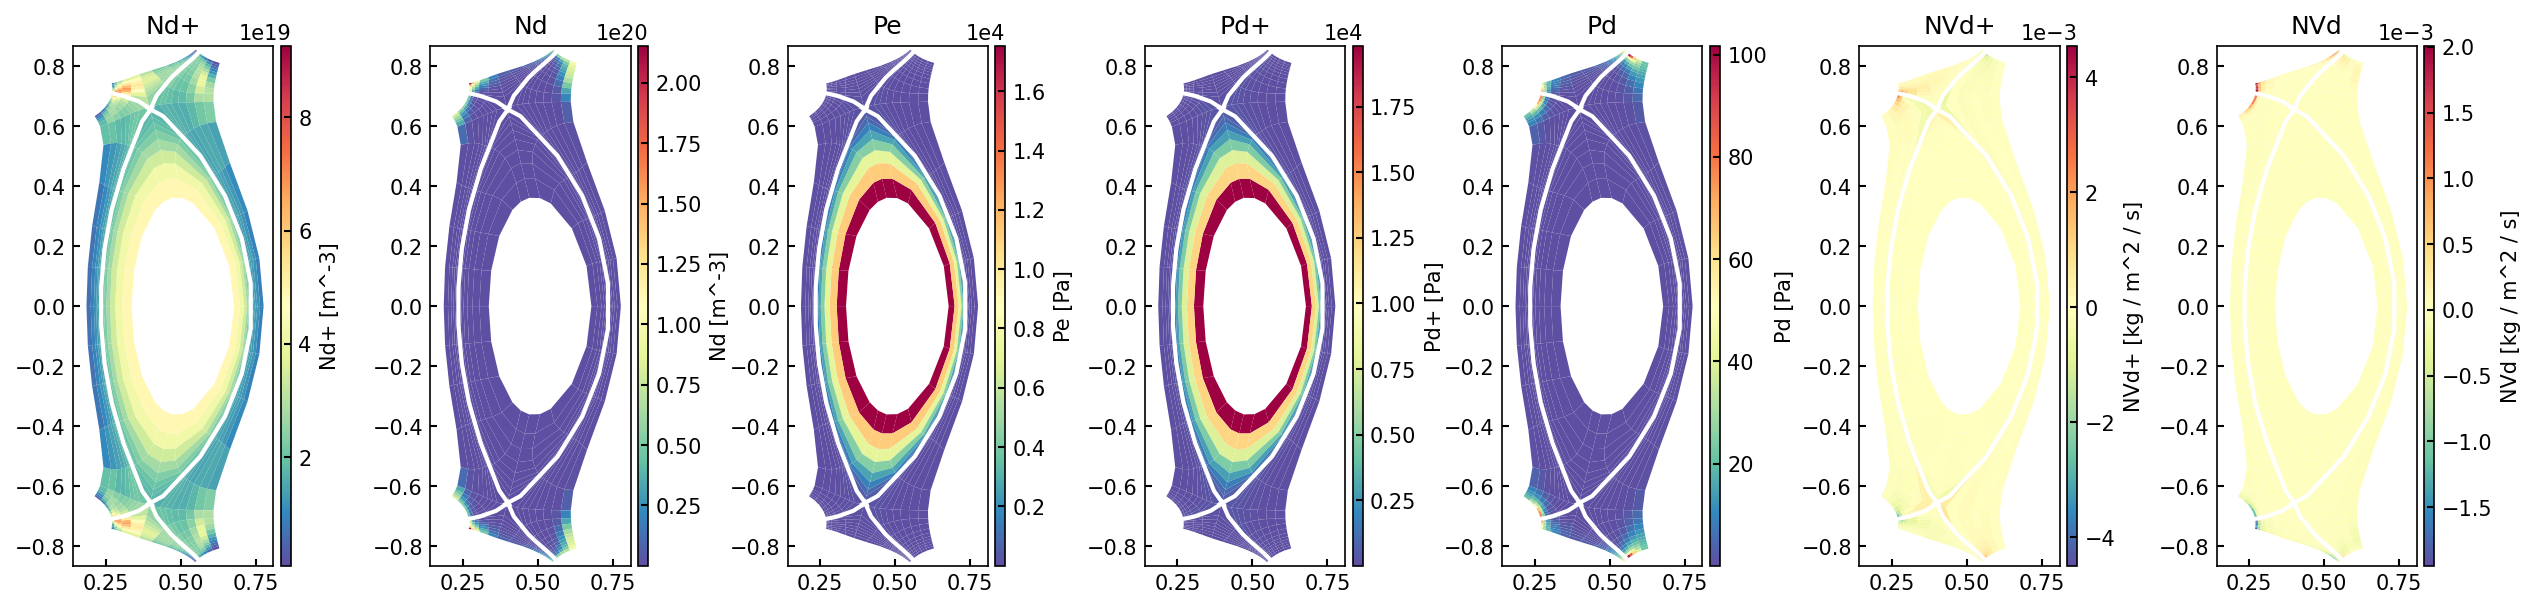

In [ ]:
fig, axes = plt.subplots(1,7, figsize = (3.0*7,4.5), dpi = 150)
cmap = "Spectral_r"

name = "fix"

ds = cs[name].ds

for i, param in enumerate(["Nd+", "Nd", "Pe", "Pd+", "Pd", "NVd+", "NVd"]):
  
  data = ds[param]
  if "t" in ds.sizes:
    data = data.isel(t=-1)
  
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                        # colorbar_label="Test",
                                                        antialias = True,
                                                        logscale = False,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")

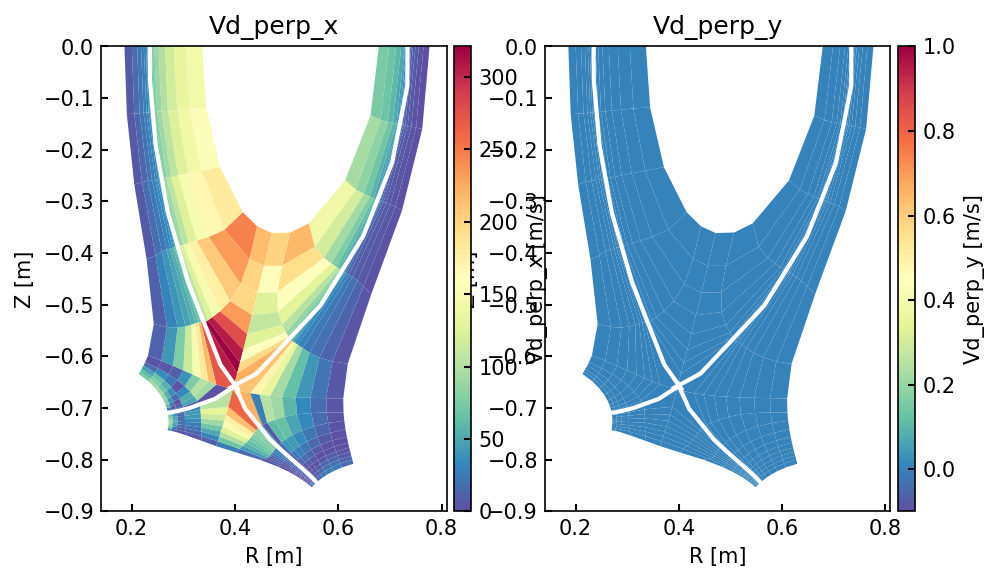

In [ ]:
cmap = "Spectral_r"

fig, axes = plt.subplots(1,2, figsize = (7,4.5), dpi = 150)

data = abs(cs["base"].ds["Vd_perp_x"])
data.hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = False,
                                                       vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                      #  vmin = -1, vmax = 1,
                                                       
                                                       )
data = abs(cs["base"].ds["Vd_perp_y"])
data.hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = False,
                                                       vmin = np.nanmin(data.values)+1, vmax = np.nanmax(data.values),
                                                      #  vmin = -1, vmax = 1,
                                                       
                                                       )

# axes[0].set_title("Vd_perp_x")
# axes[1].set_title("Test: suppress core rad")
for ax in axes:
    ax.set_ylim(-0.9, 0)


In [ ]:
ds = cs["base"].ds
hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd", "Pd", "Dnnd", "Td", "particle_flux_factor_d", "Vd_perp_x"], "omp")

hrdf["flux_hermes"] = hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"]) * hrdf["particle_flux_factor_d"]
hrdf["V_hermes"] = hrdf["flux_hermes"] / hrdf["Nd"] / hrdf["particle_flux_factor_d"]

hrdf["Grad_Pa_hermes"] = np.gradient(hrdf["Pd"], hrdf["Srad"])
hrdf["V_hermes_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"]
hrdf["V_hermes_fluxlim_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"] * hrdf["particle_flux_factor_d"]

# hrdf["vth"] = 0.25 * np.sqrt(8 * (hrdf["Td"]*constants("q_e")) / (np.pi * 2*constants("mass_p")))

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")
ax.plot(hrdf["Srad"], abs(hrdf["V_hermes"]), label = "Simulation from flux")
ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]), label = "Simulation from velocity")
ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
# ax.plot(hrdf["Srad"], hrdf["V_hermes_reconstruct"], label = "Reconstructed")
# ax.plot(hrdf["Srad"], hrdf["V_hermes_fluxlim_reconstruct"], label = "Reconstructed w. flux lim")
ax.legend(fontsize = "x-small")

ValueError: setting an array element with a sequence.